In [28]:
# ======================
#     DATASET STUFF
# ======================
import pandas as pd
dataset_path = "data/6-gon-correct-procrustes.csv"


df = pd.read_csv(dataset_path)
df = df[df.internal_nodes == 2.0].dropna(axis=1, how="all")
dataset = df[df.target_edge_length == 0.4]
dataset = dataset.drop(['target_edge_length', 'internal_nodes'], axis=1)

training = dataset.sample(frac=0.85)
testing = dataset.drop(training.index)

train_features = training.iloc[:, :12]
train_labels = training.iloc[:, -4:]

test_features = testing.iloc[:, :12]
test_labels = testing.iloc[:, -4:]

dataset.shape[0]

3300

In [29]:

# ======================
#       MODEL STUFF
# ======================
import tensorflow as tf
from tensorflow.keras import layers

model_path = "model/direct-internal-nodes-correct"
BATCH_SIZE = 64
EPOCHS = 1000

def model_setup():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(12,)),
        layers.BatchNormalization(),

        layers.Dense(12, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(12, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(4),
    ])

    return model

model = model_setup()
model.summary()

decay_steps= 10_000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, decay_steps, 1e-4)


model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=lr_schedule,
              ),
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=EPOCHS//5, min_delta=0.0001)
history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    callbacks=[checkpoint, early_stopping],
                    )

# ======================
#       EVALUATION
# ======================
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))


422
INFO:tensorflow:Assets written to: model\direct-internal-nodes-correct\assets
Epoch 31/1000
36/36 - 0s - loss: 0.0453 - val_loss: 0.0424
Epoch 32/1000
36/36 - 0s - loss: 0.0452 - val_loss: 0.0426
Epoch 33/1000
36/36 - 0s - loss: 0.0445 - val_loss: 0.0426
Epoch 34/1000
36/36 - 0s - loss: 0.0450 - val_loss: 0.0421
INFO:tensorflow:Assets written to: model\direct-internal-nodes-correct\assets
Epoch 35/1000
36/36 - 0s - loss: 0.0445 - val_loss: 0.0426
Epoch 36/1000
36/36 - 0s - loss: 0.0448 - val_loss: 0.0422
Epoch 37/1000
36/36 - 0s - loss: 0.0446 - val_loss: 0.0419
INFO:tensorflow:Assets written to: model\direct-internal-nodes-correct\assets
Epoch 38/1000
36/36 - 0s - loss: 0.0442 - val_loss: 0.0423
Epoch 39/1000
36/36 - 0s - loss: 0.0445 - val_loss: 0.0421
Epoch 40/1000
36/36 - 0s - loss: 0.0444 - val_loss: 0.0421
Epoch 41/1000
36/36 - 0s - loss: 0.0445 - val_loss: 0.0418
INFO:tensorflow:Assets written to: model\direct-internal-nodes-correct\assets
Epoch 42/1000
36/36 - 0s - loss: 0.

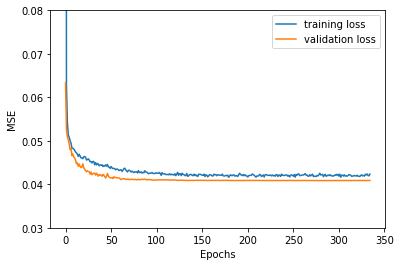

In [35]:
# ======================
#       PLOTTING
# ======================
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.ylim((0.03, 0.08))
plt.show()

meshed contour has 2.0 internal nodes!


array([ 0.09016445,  0.1375421 , -0.12917359, -0.06589413], dtype=float32)

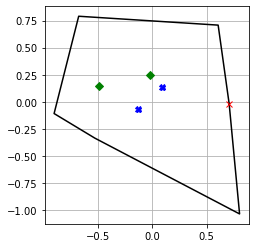

In [23]:
import pre_processing as pp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

model_path = "model/direct-internal-nodes-correct"

def prediction_pipeline(contour, model_path):
    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Load model
    loaded_model = tf.keras.models.load_model(model_path)

    # Define prediction data
    features = transformed_contour_data
    prediction_data = np.expand_dims(features, axis=0)

    # Predict
    prediction_result = loaded_model(prediction_data).numpy()

    return prediction_result



meshed_internal_node_count = -1

while meshed_internal_node_count != 2:
    contour = pp.create_random_ngon(6)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.6)
    meshed_internal_points = meshed_contour[-4:]
    meshed_internal_node_count = int(meshed_contour[13])
    print(f"meshed contour has {meshed_contour[13]} internal nodes!")

prediction_model_path = model_path
predicted_internal_nodes = prediction_pipeline(contour, model_path)[0]

# Plotting
plt.grid(b=True)

pl2 = plt.plot([meshed_internal_points[0], meshed_internal_points[2]], 
         [meshed_internal_points[1], meshed_internal_points[3]], 'gD',
            label="Internal nodes from reference mesher",
            )
pl1 = plt.plot([predicted_internal_nodes[0], predicted_internal_nodes[2]], 
               [predicted_internal_nodes[1], predicted_internal_nodes[3]], 
               'bX',
)
pl3 = pp.plot_polygon(transformed_contour, style='k')

plt.gca().set_aspect('equal')
predicted_internal_nodes